In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(gridExtra)
library(corrplot)
library(descr)
library(gmodels)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


corrplot 0.92 loaded


Attaching package: ‘gmodels’


The following object is masked from ‘package:descr’:

    CrossTable




[1] "spaceship-titanic"

# Spaceship Titanic

In this EDA - we want to explore the data and understand the steps we need to take for pre-processing.  First let's see what the data looks like.

In [2]:
#Read in the data

df1 <- read_csv('../input/spaceship-titanic/train.csv')

Rows: 8693 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): PassengerId, HomePlanet, Cabin, Destination, Name
dbl (6): Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
lgl (3): CryoSleep, VIP, Transported

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#Get overview of the data
str(df1)

spec_tbl_df [8,693 × 14] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ PassengerId : chr [1:8693] "0001_01" "0002_01" "0003_01" "0003_02" ...
 $ HomePlanet  : chr [1:8693] "Europa" "Earth" "Europa" "Europa" ...
 $ CryoSleep   : logi [1:8693] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Cabin       : chr [1:8693] "B/0/P" "F/0/S" "A/0/S" "A/0/S" ...
 $ Destination : chr [1:8693] "TRAPPIST-1e" "TRAPPIST-1e" "TRAPPIST-1e" "TRAPPIST-1e" ...
 $ Age         : num [1:8693] 39 24 58 33 16 44 26 28 35 14 ...
 $ VIP         : logi [1:8693] FALSE FALSE TRUE FALSE FALSE FALSE ...
 $ RoomService : num [1:8693] 0 109 43 0 303 0 42 0 0 0 ...
 $ FoodCourt   : num [1:8693] 0 9 3576 1283 70 ...
 $ ShoppingMall: num [1:8693] 0 25 0 371 151 0 3 0 17 0 ...
 $ Spa         : num [1:8693] 0 549 6715 3329 565 ...
 $ VRDeck      : num [1:8693] 0 44 49 193 2 0 0 NA 0 0 ...
 $ Name        : chr [1:8693] "Maham Ofracculy" "Juanna Vines" "Altark Susent" "Solam Susent" ...
 $ Transported : logi [1:8693] FALSE TRUE FALSE F

# Univariate analysis


# Target variable analysis 
First let's understand the target variable

In [4]:
#Understand the distribution of the target variable
df1 %>%
count(Transported)

Transported,n
<lgl>,<int>
FALSE,4315
TRUE,4378


The data looks balanced so no further sampling is required.


# Missing values
Next let's understand the variables that have a high proportion of missing values

In [5]:
#Calculate how many missing values there are by column
sapply(X = df1, FUN = function(x) sum(is.na(x)))

PassengerId   HomePlanet    CryoSleep        Cabin  Destination          Age 
           0          201          217          199          182          179 
         VIP  RoomService    FoodCourt ShoppingMall          Spa       VRDeck 
         203          181          183          208          183          188 
        Name  Transported 
         200            0

All the columns apart from the index and target variable have missing values.  Need to check if these are consistent for the passenger ID and remove them in pre-processing. 

In [6]:
#Count how many NAs there are per row
df1$count_na <- rowSums(is.na(df1))
df1 %>%
arrange(desc(count_na))

PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,count_na
<chr>,<chr>,<lgl>,<chr>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>
1284_01,Mars,TRUE,F/247/S,NA,NA,FALSE,0,NA,0,0,0,Hal Knité,TRUE,3
2822_02,Earth,NA,G/450/S,TRAPPIST-1e,5,NA,0,0,0,0,NA,Salley Harverez,FALSE,3
2970_01,Earth,FALSE,NA,TRAPPIST-1e,NA,FALSE,740,82,6,NA,1,Dwin Adkinson,FALSE,3
3315_01,Earth,NA,F/627/S,TRAPPIST-1e,15,FALSE,10,0,99,NA,2031,NA,FALSE,3
3790_01,NA,TRUE,G/620/P,TRAPPIST-1e,13,FALSE,0,NA,0,NA,0,Trick Meyersones,TRUE,3
4167_01,Earth,FALSE,NA,PSO J318.5-22,NA,NA,0,440,0,0,334,Ninaha Deckerson,FALSE,3
4446_05,Europa,NA,B/175/S,TRAPPIST-1e,33,FALSE,0,4017,NA,NA,2260,Phah Chocaters,TRUE,3
4840_01,NA,TRUE,F/915/S,TRAPPIST-1e,36,FALSE,0,0,NA,0,0,NA,TRUE,3
5555_01,NA,FALSE,G/896/S,NA,43,NA,1,0,213,7,701,Winia Blanglison,TRUE,3


There is no obvious pattern to the NA columns. In pre-processing, suggest to remove passengers who have more than 3 missing values. 

# Numerical variable analysis
Next let's understand the distribution of numerical variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 181 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 183 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 208 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 183 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 188 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 179 rows containing non-finite values (stat_boxplot).”


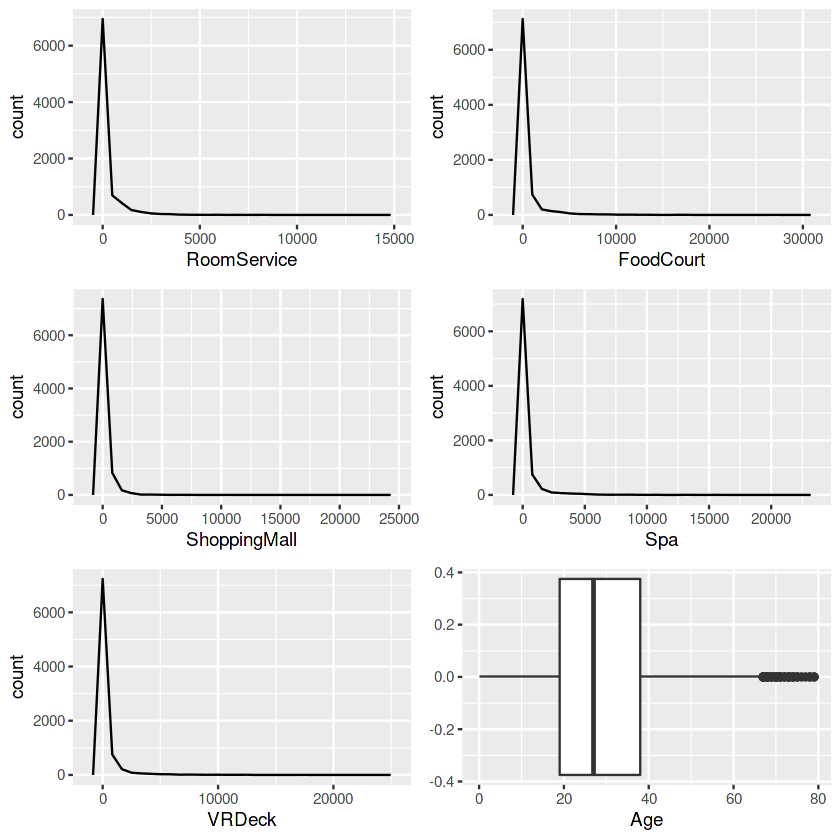

In [7]:
#Build plots to show the distribution of numerical variables
rsplot <- df1 %>%
ggplot() +
geom_freqpoly(aes(RoomService))

fcplot <- df1 %>%
ggplot() +
geom_freqpoly(aes(FoodCourt))

smplot <- df1 %>%
ggplot() +
geom_freqpoly(aes(ShoppingMall))

spaplot <- df1 %>%
ggplot() +
geom_freqpoly(aes(Spa))

VRplot <- df1 %>%
ggplot() +
geom_freqpoly(aes(VRDeck))

ageplot <- df1 %>%
ggplot() +
geom_boxplot(aes(Age))

grid.arrange(rsplot,fcplot,smplot, spaplot, VRplot, ageplot)

All the spend variables show a similar distribution, the majority of customers have no spend and so the data is highly skewed.  There are some outliers on the age data - evaluate the effect on the model with / without the outliers.

Summary of action required on numerical variables:
* Remove passengers with more than 3 missing items
* Impute missing values in numerical columns
* Test remove age outliers
* Test removing very high spends

# Categorical variables
Next lets understand the distribution of categorical variables

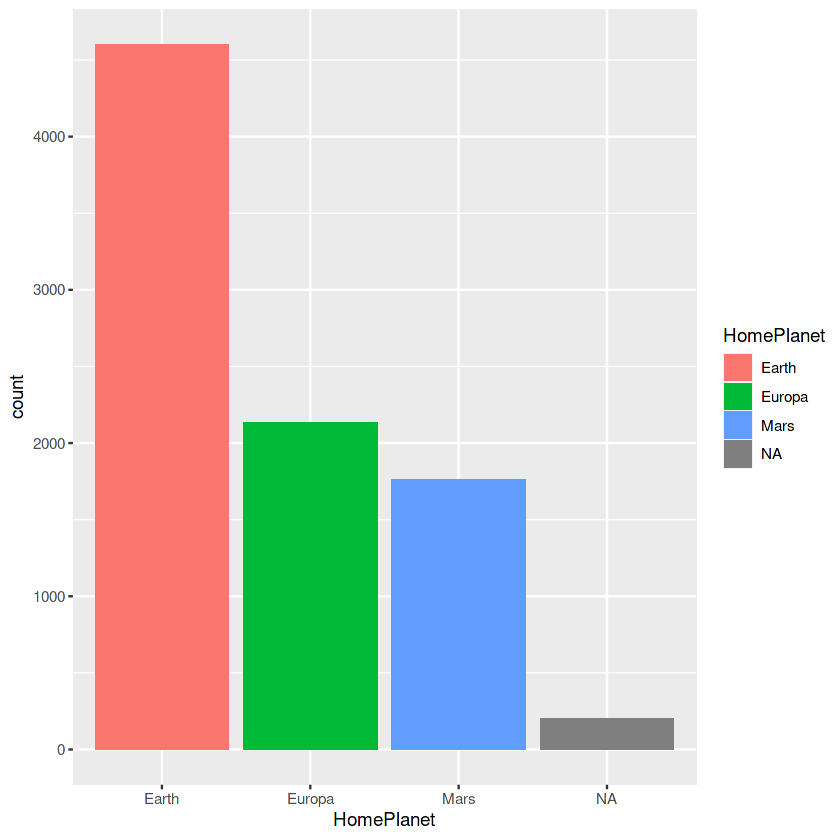

In [8]:
#Analyse the distribution planet
planetplot <- df1 %>%
ggplot()+
geom_bar(aes(HomePlanet, fill = HomePlanet)) +
scale_fill_discrete()

planetplot

The majority of people are coming from Earth - but NA is odd - need to consider in pre-processing.

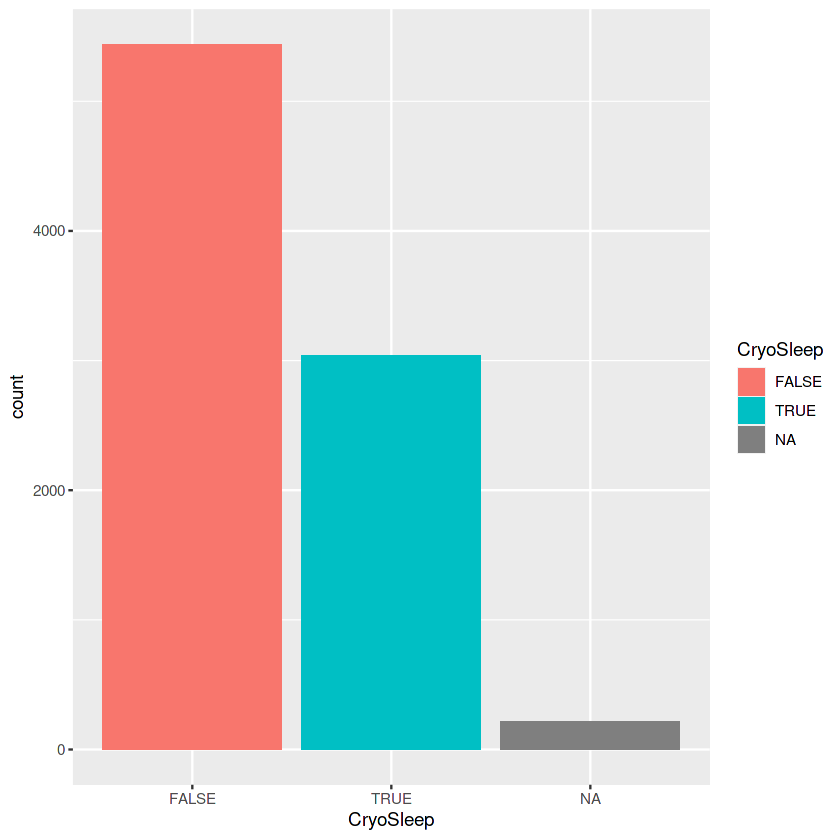

In [9]:
#Analyse the distribution of Cryosleep
cryoplot <- df1 %>%
ggplot()+
geom_bar(aes(CryoSleep, fill = CryoSleep)) +
scale_fill_discrete()

cryoplot

In [10]:
#Analyse the distribution of cabin
df1 %>%
count(Cabin, sort = TRUE)

Cabin,n
<chr>,<int>
NA,199
G/734/S,8
B/11/S,7
B/201/P,7
B/82/S,7
C/137/S,7
C/21/P,7
D/176/S,7
E/13/S,7


This data needs to be split into the deck, number and side of the ship before it can be analysed fully.

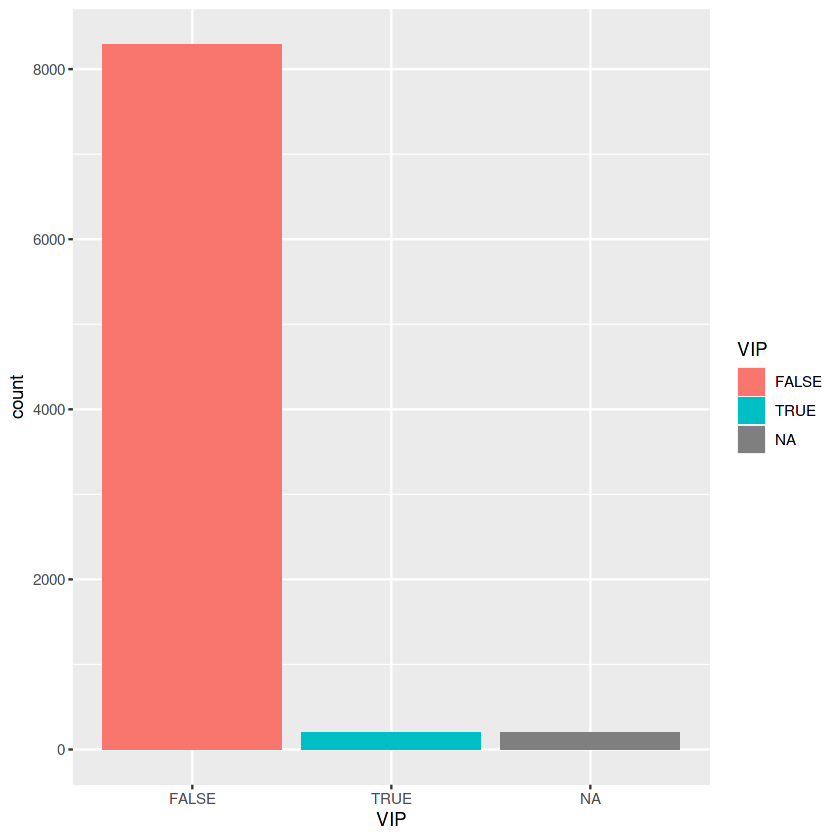

In [11]:
#Analyse the distribution of VIP
vipplot <- df1 %>%
ggplot()+
geom_bar(aes(VIP, fill = VIP)) +
scale_fill_discrete()

vipplot

Majority of people are not VIP.  Need to address the NA.

Summary of preprocessing required on categorical variables:
* Impute NA values with the mode
* Split the cabin variable
* Encode the categorical variables


# Bivariate analysis

First lets understand the effect of numerical variables on the target variable by using a simple correlation.

In [12]:
#Build the correlation table
df1 %>%
select(RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported) %>%
cor(use = "complete.obs")

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
RoomService,1.000000000,-0.01620439,0.055129139,0.009858203,-0.018251928,-0.24363821
FoodCourt,-0.016204390,1.00000000,-0.013133927,0.221767894,0.226065005,0.05067008
ShoppingMall,0.055129139,-0.01313393,1.000000000,0.016489705,-0.004490168,0.00769300
Spa,0.009858203,0.22176789,0.016489705,1.000000000,0.146568539,-0.22152030
VRDeck,-0.018251928,0.22606501,-0.004490168,0.146568539,1.000000000,-0.20755073
Transported,-0.243638213,0.05067008,0.007693000,-0.221520300,-0.207550729,1.00000000


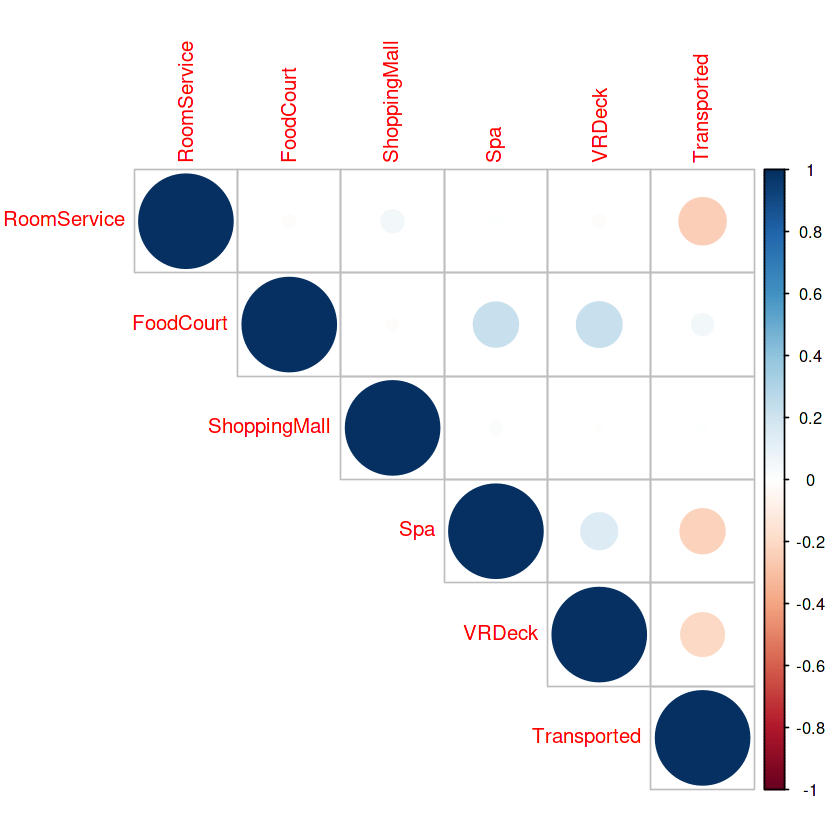

In [13]:
#Build the correlation matrix
df1 %>%
select(RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported) %>%
cor(use = "complete.obs") %>%
corrplot(type = 'upper')

Next let's understand how categorical variables affect the target.

In [14]:
#Understand the effect of planet
CrossTable(df1$HomePlanet, df1$Transported, prop.c = FALSE, prop.r = TRUE, prop.t = FALSE, expected = FALSE, prop.chi = FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  8492 

 
               | df1$Transported 
df1$HomePlanet |     FALSE |      TRUE | Row Total | 
---------------|-----------|-----------|-----------|
         Earth |      2651 |      1951 |      4602 | 
               |     0.576 |     0.424 |     0.542 | 
---------------|-----------|-----------|-----------|
        Europa |       727 |      1404 |      2131 | 
               |     0.341 |     0.659 |     0.251 | 
---------------|-----------|-----------|-----------|
          Mars |       839 |       920 |      1759 | 
               |     0.477 |     0.523 |     0.207 | 
---------------|-----------|-----------|-----------|
  Column Total |      4217 |      4275 |      8492 | 
---------------|-----------|-----------|-----------|

 


It looks like people who were coming from Europe are more likely to be transported

In [15]:
#Udnersatnd the effect of Cryosleep
CrossTable(df1$CryoSleep, df1$Transported, prop.c = FALSE, prop.r = TRUE, prop.t = FALSE, expected = FALSE, prop.chi = FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  8476 

 
              | df1$Transported 
df1$CryoSleep |     FALSE |      TRUE | Row Total | 
--------------|-----------|-----------|-----------|
        FALSE |      3650 |      1789 |      5439 | 
              |     0.671 |     0.329 |     0.642 | 
--------------|-----------|-----------|-----------|
         TRUE |       554 |      2483 |      3037 | 
              |     0.182 |     0.818 |     0.358 | 
--------------|-----------|-----------|-----------|
 Column Total |      4204 |      4272 |      8476 | 
--------------|-----------|-----------|-----------|

 


It looks like people who were put to Cryosleep are more likely to be transported.

In [16]:
#Understand the effect of VIP
CrossTable(df1$VIP, df1$Transported, prop.c = FALSE, prop.r = TRUE, prop.t = FALSE, expected = FALSE, prop.chi = FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  8490 

 
             | df1$Transported 
     df1$VIP |     FALSE |      TRUE | Row Total | 
-------------|-----------|-----------|-----------|
       FALSE |      4093 |      4198 |      8291 | 
             |     0.494 |     0.506 |     0.977 | 
-------------|-----------|-----------|-----------|
        TRUE |       123 |        76 |       199 | 
             |     0.618 |     0.382 |     0.023 | 
-------------|-----------|-----------|-----------|
Column Total |      4216 |      4274 |      8490 | 
-------------|-----------|-----------|-----------|

 


In [17]:
VIPs are less likely to be transported

ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: unexpected symbol
1: VIPs are
         ^


# Summary of pre-processing actions required


Summary of action required on numerical variables:

* Remove passengers with more than 3 missing items
* Impute missing values in numerical columns
* Test remove age outliers
* Test removing very high spends  

Summary of preprocessing required on categorical variables:

Impute NA values with the mode
Split the cabin variable
Encode the categorical variables